# Assignment 1B

# Import Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn is another good plotting library. In particular, I like it for heatmaps (https://seaborn.pydata.org/generated/seaborn.heatmap.html)
import seaborn as sns;
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

import time

## Q1
import os
import datetime

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC, NuSVC
from tensorflow.keras.callbacks import ModelCheckpoint


# tf.keras.backend.clear_session()

## Q2
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

import random
from tensorflow.keras import backend as K

# To export as pdf with better quality plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')


Mounted at /content/drive


# Problem 1. Training and Adapting Deep Networks.

Using these datasets you are to:
1. Train a Linear One vs One SVM (with C = 1), on the provided abridged SVHN
training set.
2. Design/select a DCNN architecture and using this one architecture:

  (a) Train a model from scratch, using no data augmentation, on the provided abridged
SVHN training set.

  (b) Train a model from scratch, using the data augmentation of your choice, on the
provided abridged SVHN training set.

  (c) Fine tune an existing model, trained on another dataset used in CAB420 (such
as MNIST, KMINST or CIFAR), on the provided abridged SVHN training set.
Data augmentation may also be used if you so choose.
3. Compare the performance of the four, considering the accuracy, training time and
inference time (i.e. time taken to evaluate the models), using the provided test set.

All models should be evaluated on the provided SVHN test set, and their performance should
be compared. DCNN architectures and pre-trained models may be taken from lecture ex-
amples or practical solutions. Your selection of model may take computational constraints
into consideration.

You have been provided with sample python code that will load and prepare the dataset for
training for both the One vs One SVM, and DCNN. Sample code also illustrates how you can
time a process with Python, and how to resize images and convert them to greyscale if this
is required for your approach. Note that any pre-processing (i.e. resizing of images, colour
conversion) should be applied for all models (SVM and DCNNs) to enable a fair comparison.

In [ ]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#

from scipy.io import loadmat        # to load mat files
import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for colour conversion
import tensorflow as tf             # for bulk image resize

# Load data for Q1
#  train_path: path to training data mat file
#  test_path:  path to testing data mat file
#
#  returns:    arrays for training and testing X and Y data
#
def load_data(train_path, test_path):

    # load files
    train = loadmat(train_path)
    test = loadmat(test_path)

    # transpose, such that dimensions are (sample, width, height, channels), and divide by 255.0
    train_X = np.transpose(train['train_X'], (3, 0, 1, 2)) / 255.0
    train_Y = train['train_Y']
    # change labels '10' to '0' for compatability with keras/tf. The label '10' denotes the digit '0'
    train_Y[train_Y == 10] = 0
    train_Y = np.reshape(train_Y, -1)

    # transpose, such that dimensions are (sample, width, height, channels), and divide by 255.0
    test_X = np.transpose(test['test_X'], (3, 0, 1, 2)) / 255.0
    test_Y = test['test_Y']
    # change labels '10' to '0' for compatability with keras/tf. The label '10' denotes the digit '0'
    test_Y[test_Y == 10] = 0
    test_Y = np.reshape(test_Y, -1)

    # return loaded data
    return train_X, train_Y, test_X, test_Y

# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Plot some images and their labels. Will plot the first 100 samples in a 10x10 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1)
        ax.imshow(x[i,:])
        ax.set_title(y[i])
        ax.axis('off')

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_BGR2GRAY))
    # pack converted list as an array and return
    return np.array(gray)

In [ ]:
# Load the data
train_path = '/content/drive/My Drive/Assignment 1B/CAB420_Assessment_1B_Data/Q1/q1_train.mat'
test_path = '/content/drive/My Drive/Assignment 1B/CAB420_Assessment_1B_Data/Q1/q1_test.mat'

train, train_y, test, test_y = load_data(train_path, test_path)

In [ ]:
## Convert to greyscale and resize
train = convert_to_grayscale(resize(train, (28, 28)))
test = convert_to_grayscale(resize(test, (28, 28)))

print(np.shape(train))
print(np.shape(test))

(1000, 28, 28)
(10000, 28, 28)


In [ ]:
## Set constants
num_epochs = 20
batch_size = 8
steps_per_epoch = 100



---



## 1. Train a Linear One vs One SVM (with C = 1), on the provided abridged SVHN training set.

In [ ]:
## Vectorise for SVM
train_vector_X = vectorise(train)
test_vector_X = vectorise(test)

print(train_vector_X.shape)
print(test_vector_X.shape)

(1000, 784)
(10000, 784)


In [ ]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize="true", xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)

    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));

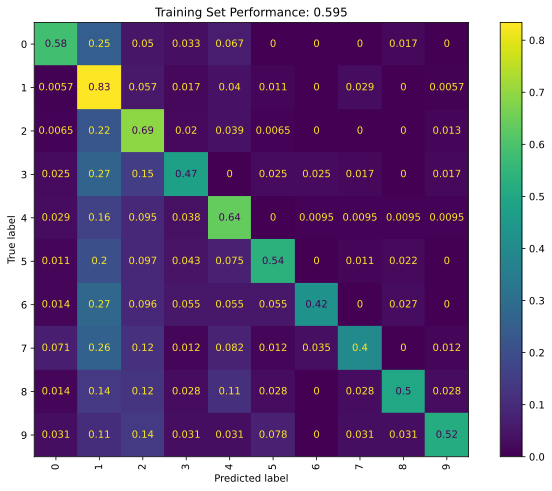

In [ ]:
## SVM
C = 1; kernel = 'linear'
params = {'C': 1, 'kernel': 'linear'}
svm = SVC().set_params(**params)
svm.fit(train_vector_X, train_y)
eval_model(svm, train_vector_X, train_y)



---



---



## 2. Design/select a DCNN architecture and using this one architecture:



In [ ]:
## Reshape data
train = train.reshape(-1, 28, 28, 1)
test = test.reshape(-1, 28, 28, 1)

train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

print(np.shape(train))
print(np.shape(train_y))
print(np.shape(test))
print(np.shape(test_y))

(1000, 28, 28, 1)
(1000, 1)
(10000, 28, 28, 1)
(10000, 1)


In [ ]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 6])

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(np.unique(y_test))))
    c.plot(ax = ax)

    print(classification_report(y_test, indexes))

In [ ]:
# num_epochs = 20

# function to build a model, takes the number of classes. Can optionally change the output activation.
# See the discussion at bottom of this script for more details about that.
def build_model(num_classes, output_activation=None, with_augmentation = False):
    # our model, input in an image shape
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')

    if (with_augmentation):
      x = data_augmentation(inputs)
    #   x = layers.Conv2D(16, 3, activation='swish')(x)
    # else:
    #   x = layers.Conv2D(16, 3, activation='swish')(inputs)

    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')

    return model_cnn

model_cnn = build_model(10)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_120 (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 conv2d_121 (Conv2D)         (None, 28, 28, 8)         584       
                                                                 
 batch_normalization_62 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 activation_62 (Activation)  (None, 28, 28, 8)         0         
                                                                 
 spatial_dropout2d_60 (Spati  (None, 28, 28, 8)        0         
 alDropout2D)                                     

### (a) Train a model from scratch, using no data augmentation, on the provided abridged SVHN training set.

In [ ]:
tic = time.perf_counter()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(test, test_y,
                        batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch,
                        epochs=num_epochs,
                        validation_data=(train, train_y))
toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Training Timer: {timer} seconds')

Epoch 1/20
100/100 [==============================] - 4s 27ms/step - loss: 2.4908 - accuracy: 0.1462 - val_loss: 2.2704 - val_accuracy: 0.1750
Epoch 2/20
100/100 [==============================] - 2s 25ms/step - loss: 2.3320 - accuracy: 0.1550 - val_loss: 2.2679 - val_accuracy: 0.1750
Epoch 3/20
100/100 [==============================] - 2s 25ms/step - loss: 2.2883 - accuracy: 0.1600 - val_loss: 2.2561 - val_accuracy: 0.1760
Epoch 4/20
100/100 [==============================] - 3s 26ms/step - loss: 2.2742 - accuracy: 0.1850 - val_loss: 2.2443 - val_accuracy: 0.1750
Epoch 5/20
100/100 [==============================] - 2s 25ms/step - loss: 2.2451 - accuracy: 0.1725 - val_loss: 2.2180 - val_accuracy: 0.1930
Epoch 6/20
100/100 [==============================] - 3s 25ms/step - loss: 2.2004 - accuracy: 0.1937 - val_loss: 2.1680 - val_accuracy: 0.2620
Epoch 7/20
100/100 [==============================] - 2s 25ms/step - loss: 2.1621 - accuracy: 0.2387 - val_loss: 2.0637 - val_accuracy: 0.2830

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       711
           1       0.96      0.95      0.96      1894
           2       0.97      0.95      0.96      1497
           3       0.90      0.91      0.91      1141
           4       0.92      0.97      0.94      1035
           5       0.88      0.92      0.90       892
           6       0.88      0.86      0.87       758
           7       0.91      0.95      0.93       789
           8       0.95      0.77      0.85       683
           9       0.89      0.89      0.89       600

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000

Inference Timer: 0:00:04.295984 seconds


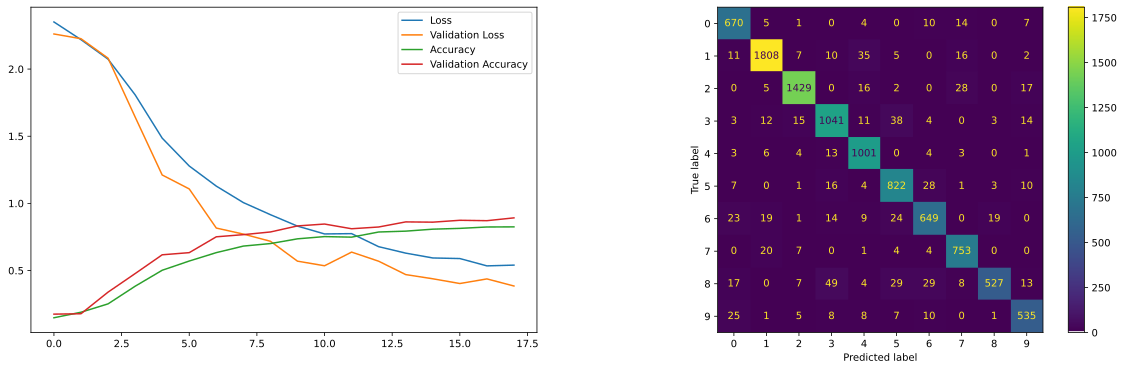

In [ ]:
tic = time.perf_counter()
eval_model(model_cnn, history.history, train, train_y, test, test_y)
toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Inference Timer: {timer} seconds')

### (b) Train a model from scratch, using the data augmentation of your choice, on the provided abridged SVHN training set.

In [ ]:
print(train.shape)

(1000, 28, 28, 1)


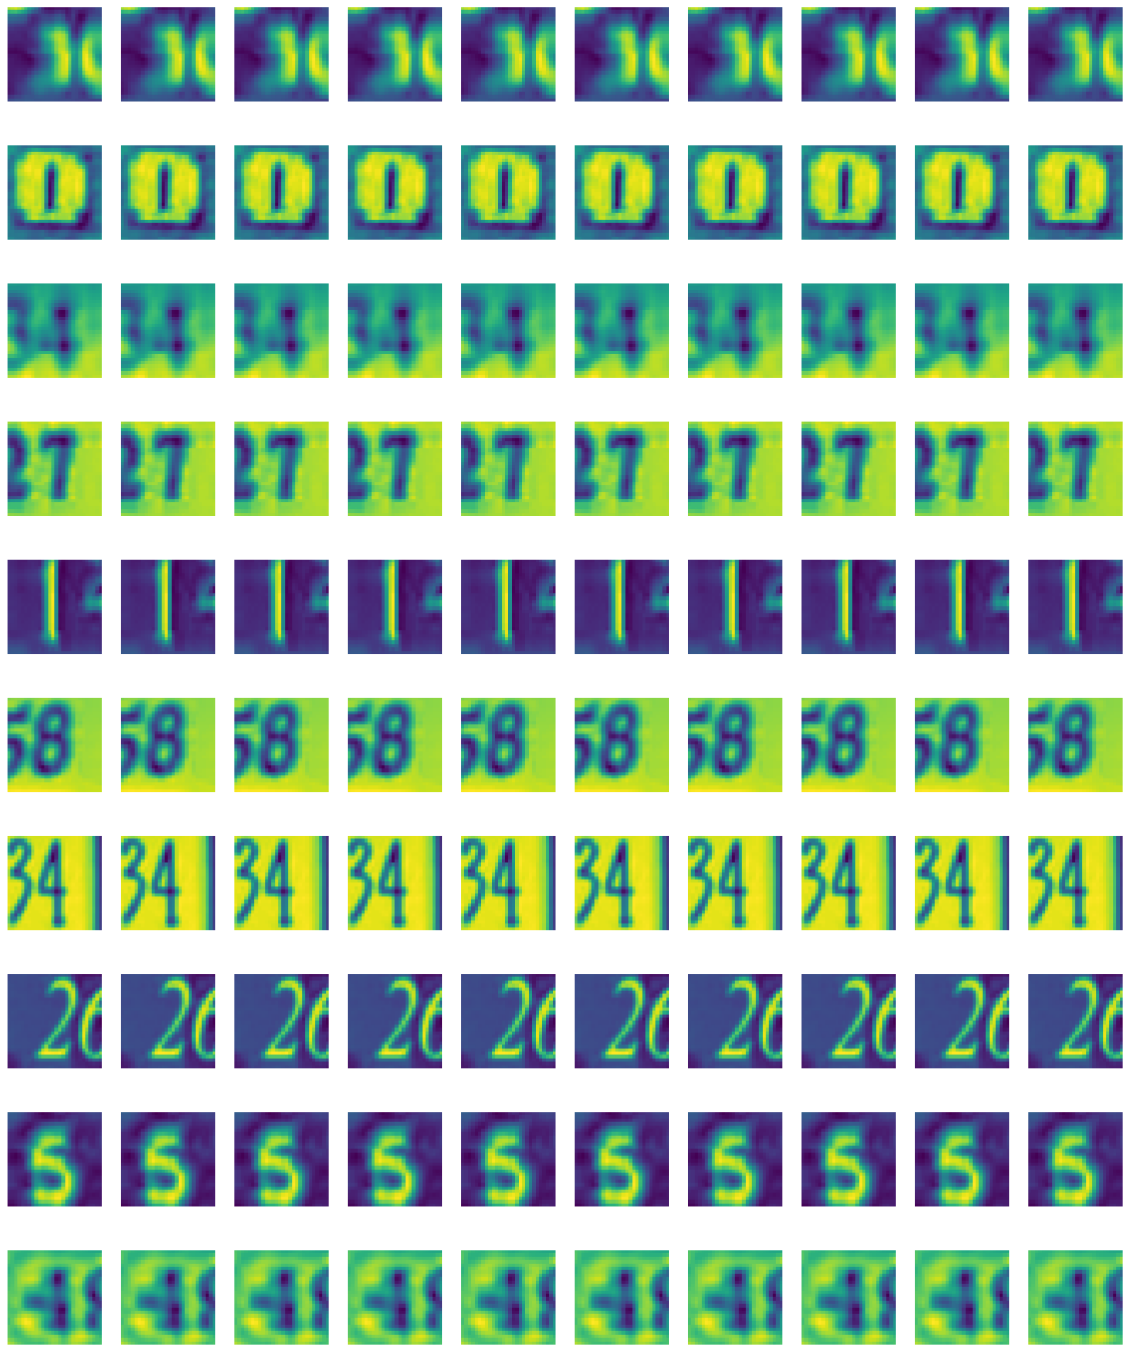

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.10),
  layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
  layers.RandomZoom(0.1)
])

fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(train[i,:,:,:],0))
        plt.imshow(vectorise(augmented_image[0]))
        plt.axis("off")

# fig = plt.figure(figsize=[20, 25])
# for i in range(10):
#     for j in range(10):
#         ax = fig.add_subplot(10, 10, i*10 + (j + 1))
#         augmented_image = data_augmentation(tf.expand_dims(train[i,:,:,:],0))
#         img2 = vectorise(augmented_image)
#         ax.imshow(img2)
        # plt.imshow(augmented_image[0])
        # plt.axis("off")

#         batch = datagen.flow(train, train_y, batch_size=100)

# fig = plt.figure(figsize=[20, 25])
# for i,img in enumerate(batch[0][0]):
#     ax = fig.add_subplot(10, 10, i + 1)
#     img2 = vectorise(img)
#     ax.imshow(img2)

In [ ]:
## Refresh model
model_cnn = build_model(10, with_augmentation = True)

tic = time.perf_counter()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y, batch_size=8,
                        steps_per_epoch = 100,
                        epochs=20,
                        validation_data=(test, test_y), verbose=True)
toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Training Timer: {timer} seconds')

# dataset.repeat(num_epochs).batch(batch_size)


# history = magic_property_forecaster_no_aug.fit(train, train_y, batch_size=32,
#                     epochs=50,
#                     validation_data=(test, test_y), verbose=True)

# eval(magic_property_forecaster_no_aug, history.history, test, test_y)

Epoch 1/20
100/100 [==============================] - 12s 105ms/step - loss: 2.5487 - accuracy: 0.1388 - val_loss: 2.2880 - val_accuracy: 0.1035
Epoch 2/20
100/100 [==============================] - 8s 76ms/step - loss: 2.3627 - accuracy: 0.1437 - val_loss: 2.2522 - val_accuracy: 0.1696
Epoch 3/20
100/100 [==============================] - 8s 77ms/step - loss: 2.3187 - accuracy: 0.1312 - val_loss: 2.2600 - val_accuracy: 0.1878
Epoch 4/20
100/100 [==============================] - 8s 77ms/step - loss: 2.2973 - accuracy: 0.1562 - val_loss: 2.2399 - val_accuracy: 0.1894
Epoch 5/20
100/100 [==============================] - 8s 77ms/step - loss: 2.2716 - accuracy: 0.1625 - val_loss: 2.2333 - val_accuracy: 0.2011
Epoch 6/20
100/100 [==============================] - 8s 78ms/step - loss: 2.2604 - accuracy: 0.1475 - val_loss: 2.2326 - val_accuracy: 0.1539
Epoch 7/20
100/100 [==============================] - 8s 76ms/step - loss: 2.2183 - accuracy: 0.1900 - val_loss: 2.1773 - val_accuracy: 0.24

              precision    recall  f1-score   support

           0       0.74      0.14      0.24       711
           1       0.62      0.93      0.74      1894
           2       0.71      0.78      0.75      1497
           3       0.46      0.49      0.47      1141
           4       0.60      0.79      0.68      1035
           5       0.60      0.67      0.63       892
           6       0.53      0.47      0.50       758
           7       0.63      0.57      0.60       789
           8       0.66      0.25      0.37       683
           9       0.74      0.17      0.27       600

    accuracy                           0.61     10000
   macro avg       0.63      0.53      0.52     10000
weighted avg       0.62      0.61      0.58     10000

Inference Timer: 0:00:04.178070 seconds


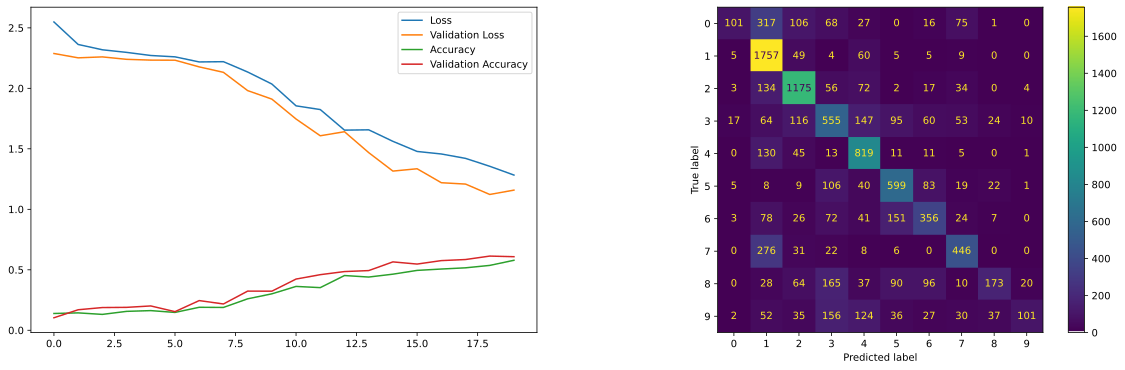

In [ ]:
tic = time.perf_counter()
eval_model(model_cnn, history.history, train, train_y, test, test_y)
toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Inference Timer: {timer} seconds')

### (c) Fine tune an existing model, trained on another dataset used in CAB420 (such as MNIST, KMINST or CIFAR), on the provided abridged SVHN training set.Data augmentation may also be used if you so choose.

In [ ]:
## FROM LOTS OF VGG LIKE MODELS ##

In [ ]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)

    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)

    return x


def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):

    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))

    x = layers.Flatten()(x)

    for i in fc:
        x = fc_block(x, i, dropout)

    return x

In [ ]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs):

    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

    model.load_weights(filename)
    model.save(filename)

    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')


    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    ax.set_title('Training')

    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    ax.set_title('Testing')

In [ ]:
# batch_size = 128;
# num_epochs = 10;

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

4431872/4422102 [==============================] - 0s 0us/step


Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 1.3018 - accuracy: 0.5587
Epoch 1: val_loss improved from inf to 2.21273, saving model to vgg_2stage_FashionMNIST_small.h5
100/100 [==============================] - 12s 103ms/step - loss: 1.3018 - accuracy: 0.5587 - val_loss: 2.2127 - val_accuracy: 0.2228
Epoch 2/20
 98/100 [============================>.] - ETA: 0s - loss: 0.8742 - accuracy: 0.7015
Epoch 2: val_loss improved from 2.21273 to 1.76923, saving model to vgg_2stage_FashionMNIST_small.h5
100/100 [==============================] - 9s 95ms/step - loss: 0.8707 - accuracy: 0.7013 - val_loss: 1.7692 - val_accuracy: 0.3923
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.8294 - accuracy: 0.7071
Epoch 3: val_loss improved from 1.76923 to 0.84148, saving model to vgg_2stage_FashionMNIST_small.h5
100/100 [==============================] - 7s 71ms/step - loss: 0.8286 - accuracy: 0.7063 - val_loss: 0.8415 - val_accuracy: 0.7071
Epoch 4/20
 99/

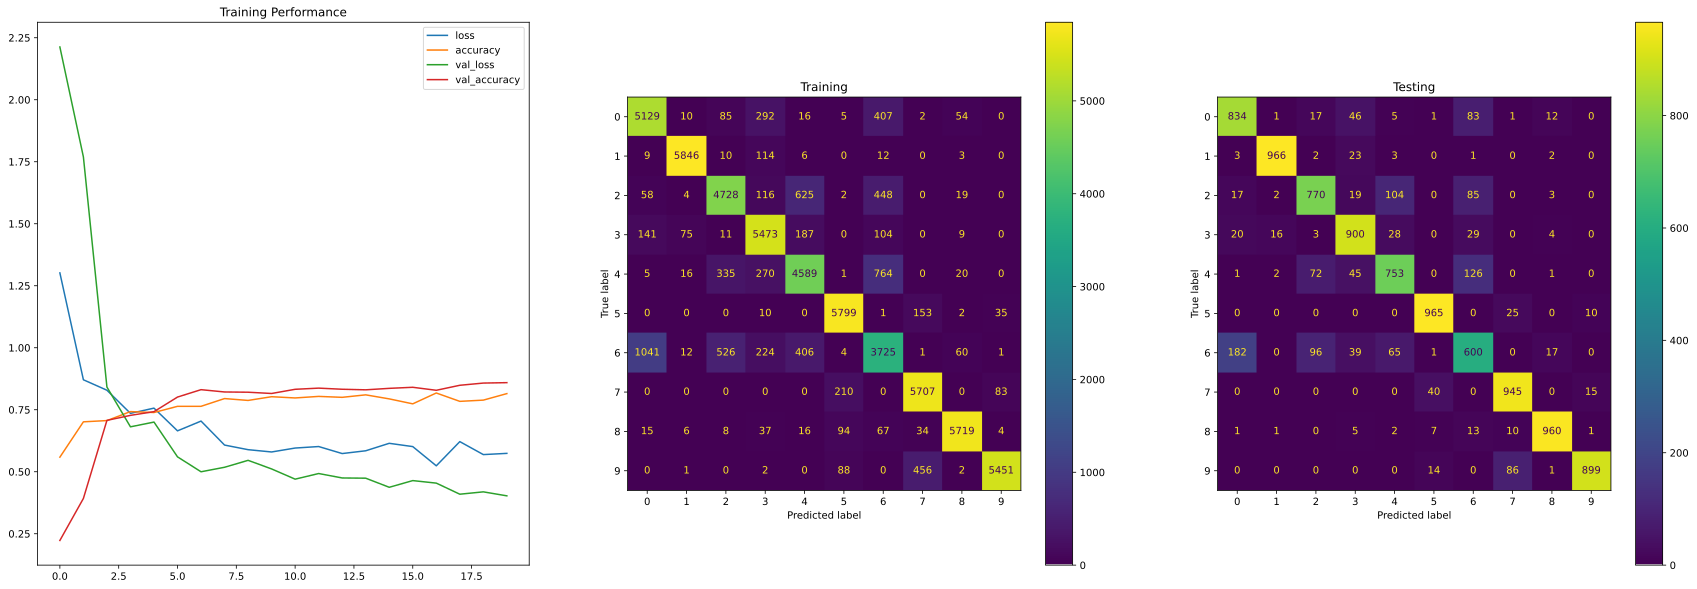

In [ ]:
tic = time.perf_counter()

inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_FashionMNIST_small.h5', batch_size, num_epochs)

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Timer: {timer} seconds')

### Re-Train Using Our Data

In [ ]:
## Re-train model using our data
tic = time.perf_counter()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(test, test_y,
                        batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch,
                        epochs=num_epochs,
                        validation_data=(train, train_y))
toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Training Timer: {timer} seconds')

Epoch 1/20
100/100 [==============================] - 4s 26ms/step - loss: 3.3318 - accuracy: 0.1587 - val_loss: 2.6074 - val_accuracy: 0.1720
Epoch 2/20
100/100 [==============================] - 2s 24ms/step - loss: 2.5394 - accuracy: 0.1900 - val_loss: 2.0597 - val_accuracy: 0.2800
Epoch 3/20
100/100 [==============================] - 2s 24ms/step - loss: 2.2895 - accuracy: 0.2575 - val_loss: 1.9574 - val_accuracy: 0.3130
Epoch 4/20
100/100 [==============================] - 2s 24ms/step - loss: 2.0919 - accuracy: 0.2975 - val_loss: 1.7848 - val_accuracy: 0.3740
Epoch 5/20
100/100 [==============================] - 2s 24ms/step - loss: 1.9846 - accuracy: 0.3300 - val_loss: 1.6585 - val_accuracy: 0.4780
Epoch 6/20
100/100 [==============================] - 2s 24ms/step - loss: 1.9150 - accuracy: 0.3875 - val_loss: 1.7002 - val_accuracy: 0.4630
Epoch 7/20
100/100 [==============================] - 2s 23ms/step - loss: 1.8019 - accuracy: 0.4275 - val_loss: 1.5484 - val_accuracy: 0.4950

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       711
           1       0.88      0.94      0.91      1894
           2       0.91      0.93      0.92      1497
           3       0.96      0.69      0.80      1141
           4       0.76      0.96      0.85      1035
           5       0.78      0.91      0.84       892
           6       0.84      0.85      0.85       758
           7       0.97      0.84      0.90       789
           8       0.88      0.70      0.78       683
           9       0.92      0.79      0.85       600

    accuracy                           0.87     10000
   macro avg       0.87      0.85      0.86     10000
weighted avg       0.87      0.87      0.86     10000

Inference Timer: 0:00:03.962496 seconds


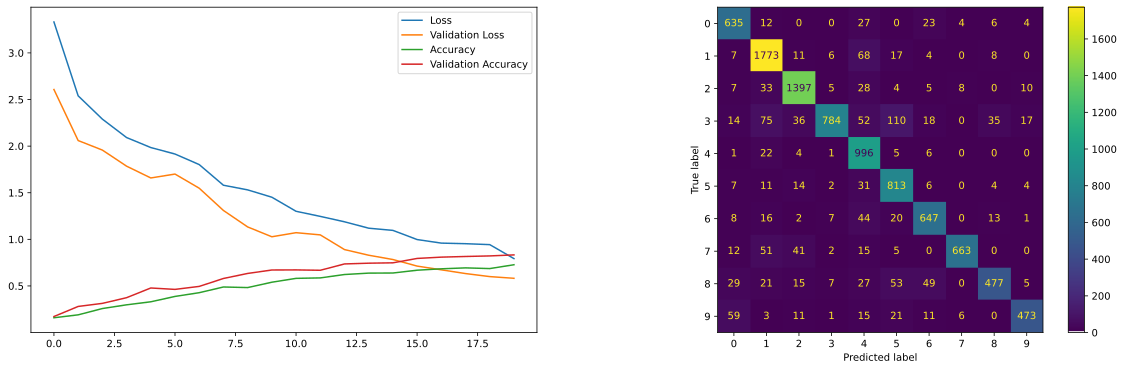

In [ ]:
tic = time.perf_counter()
eval_model(model_cnn, history.history, train, train_y, test, test_y)
toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Inference Timer: {timer} seconds')



---



## 3. Compare the performance of the four, considering the accuracy, training time and inference time (i.e. time taken to evaluate the models), using the provided test set.

In [ ]:
# Written in report



---



# Problem 2. Person Re-Identification.
Using this data, you are to:
1. Develop and a non-deep learning method using one of the dimension reduction meth-
ods covered in Week 6 for person re-identification. The method should be evaluated on
the test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative
match characteristic) curve should also be provided.
2. Develop and evaluate a deep learning based method for person re-identification,
using one of the methods covered in Week 7. The method should be evaluated on the
test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative
match characteristic) curve should also be provided.
3. Compare the performance of the two methods. Are there instances where the non-deep
learning method works better? Comment on the respective strengths and weaknesses
of the two approaches.

You have been provided with sample python code to:

-  load all images, and to transform them into a vectorised representation for non-deep
learning methods;

-  resize images and transform the images to greyscale, which you may or may not wish
to use;

-  build image pairs or triplets for use with metric learning methods;
 plot a CMC curve given a set of distances between gallery and probe samples.

In [ ]:
#
# Utility functions for CAB420, Assignment 1B, Q2
# Author: Simon Denman (s.denman@qut.edu.au)
#

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random


# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
#
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []

    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))

    return np.array(x), np.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training'
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):

    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))

    return train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')

# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.array(gray)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);

    for i in range(batch_size):

        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

# Generator to continually produce batches of Siamese Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate
#
#   yields:     image pairs and labels to indicate if the pairs are the same, or different
#
def pair_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = get_siamese_data(imgs, labels, batch_size)
        yield [image_a, image_b], label

# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));

    for i in range(batch_size):

        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Generator to continually produce batches of Triplet Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate
#
#   yields:     triplet of the requested batch size
#
def triplet_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = get_triplet_data(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None


# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Negative')


# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and
#    all gallery samples. In this case it is the L1 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1.
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L1 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with
#                 large feature sets, and/or lots of samples
#
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):

    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')

    if verbose:
        print(ranked_histogram)

    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])

    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')

In [ ]:
## Load the data
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('/content/drive/My Drive/Assignment 1B/CAB420_Assessment_1B_Data/Q2/Q2')

## Save original values
train_X_org = train_X
train_Y_org = train_Y
gallery_X_org = gallery_X
gallery_Y_org = gallery_Y
probe_X_org = probe_X
probe_Y_org = probe_Y

In [ ]:
## Resize the data
train_X_small = resize(train_X, (64, 32))
gallery_X_small = resize(gallery_X, (64, 32))
probe_X_small = resize(probe_X, (64, 32))

print(train_X_small.shape)
print(gallery_X_small.shape)
print(probe_X_small.shape)

(5933, 64, 32, 3)
(301, 64, 32, 3)
(301, 64, 32, 3)


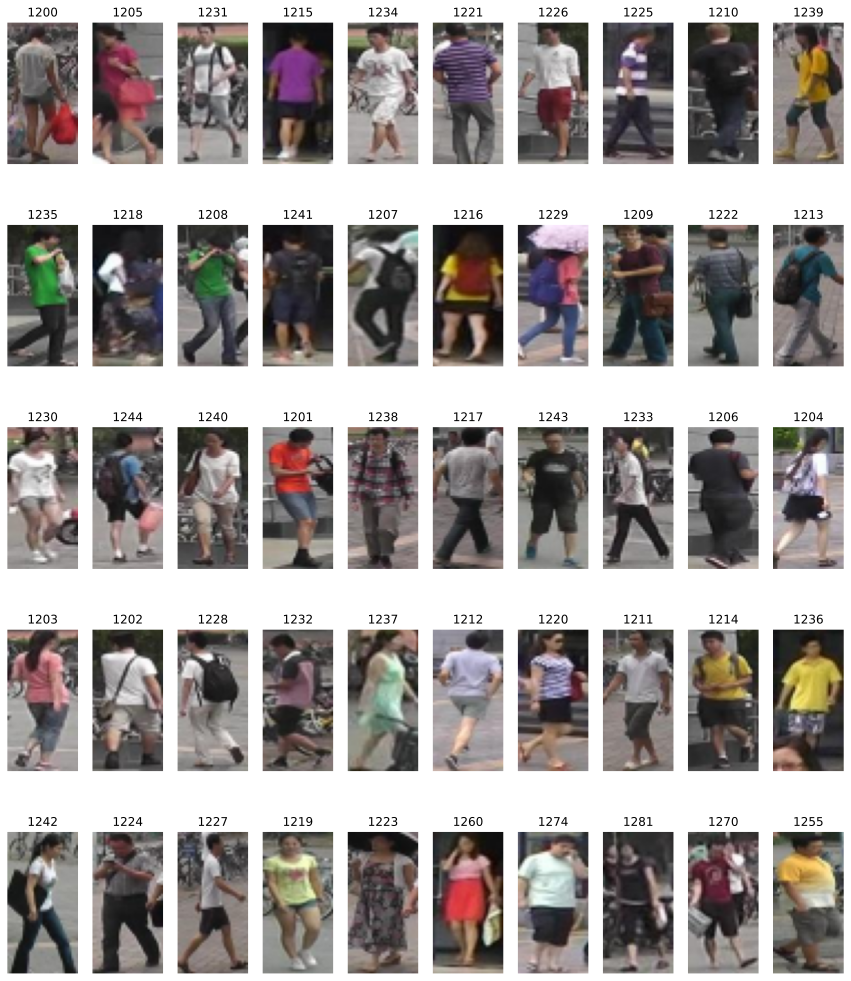

In [ ]:
# plot some resized images
plot_images(gallery_X_small, gallery_Y)



---



## 1. Develop and a non-deep learning method using one of the dimension reduction methods covered in **Week 6** for person re-identification.
The method should be evaluated on the test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative match characteristic) curve should also be provided.

In [ ]:
## Vectorise data
train_X_vec = vectorise(train_X_small)
gallery_X_vec = vectorise(gallery_X_small)
probe_X_vec = vectorise(probe_X_small)

### Train PCA Network

In [ ]:
tic = time.perf_counter()

pca = decomposition.PCA()
pca.fit(train_X_vec)

transformed = pca.transform(train_X_vec)
transformed_gallery = pca.transform(gallery_X_vec)
transformed_probe = pca.transform(probe_X_vec)

cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Training Timer: {timer} seconds')

Training Timer: 0:01:21.954921 seconds


### Plot CMC

[1.7394124e-01 1.1590346e-01 6.3110031e-02 ... 3.6700174e-12 3.5085324e-12
 1.7095068e-13]
Samples in Rank-1: 11 
Samples in Rank-1: 2  
Samples in Rank-1: 1 
Inference Timer: 0:00:01.189961 seconds


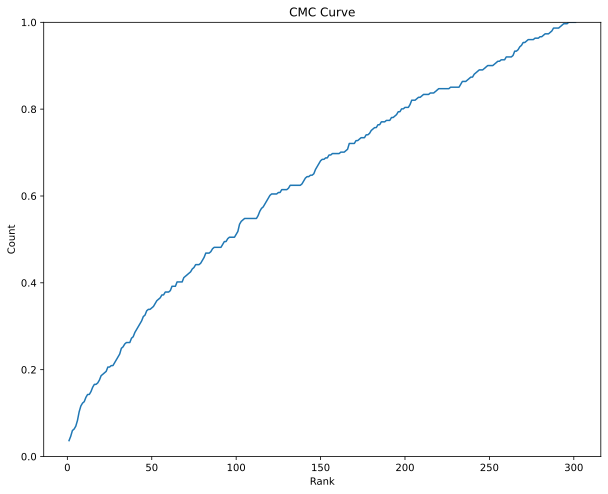

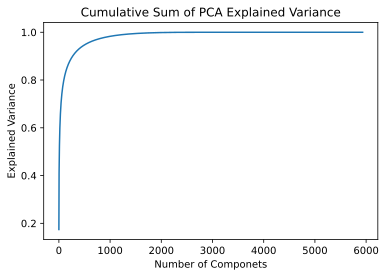

In [ ]:
tic = time.perf_counter()

ranked_hist = get_ranked_histogram_l1_distance(transformed_gallery, gallery_Y, transformed_probe, probe_Y)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

print(pca.explained_variance_ratio_)

print('Samples in Rank-1: %d ' % (ranked_hist[0]))
print('Samples in Rank-1: %d  ' % (ranked_hist[4]))
print('Samples in Rank-1: %d ' % (ranked_hist[9]))

cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Componets')

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Inference Timer: {timer} seconds')

### Train LDA Network

In [ ]:
tic = time.perf_counter()

pca_coeff_for_lda = 1024 - len(np.unique(train_X_vec))

transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_gallery_for_lda = transformed_gallery[:, 0:pca_coeff_for_lda]
transformed_probe_for_lda = transformed_probe[:, 0:pca_coeff_for_lda]

lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(np.array(transformed_train_for_lda), np.array(train_Y))
transformed = lda.transform(transformed_train_for_lda)
print(np.shape(transformed))
transformed_gallery = lda.transform(transformed_gallery_for_lda)
transformed_probe = lda.transform(transformed_probe_for_lda)

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Training Timer: {timer} seconds')

(5933, 299)
Training Timer: 0:01:41.507781 seconds


### Plot CMC

[1.7394124e-01 1.1590346e-01 6.3110031e-02 ... 3.6700174e-12 3.5085324e-12
 1.7095068e-13]
Samples in Rank-1: 1 
Samples in Rank-5: 4  
Samples in Rank-10: 1 
Inference Timer: 0:00:00.198185 seconds


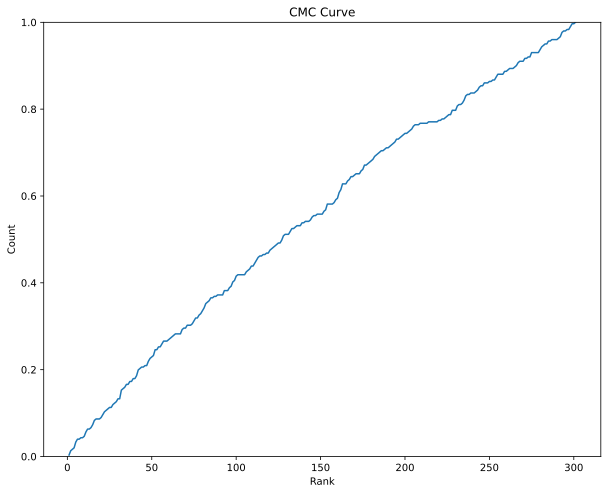

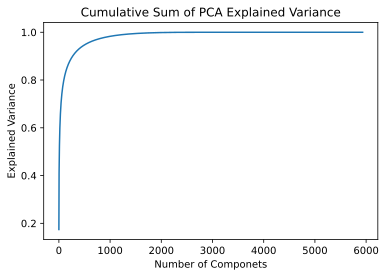

In [ ]:
tic = time.perf_counter()

ranked_hist = get_ranked_histogram_l1_distance(transformed_gallery, gallery_Y, transformed_probe, probe_Y)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

print(pca.explained_variance_ratio_)

print('Samples in Rank-1: %d ' % (ranked_hist[0]))
print('Samples in Rank-5: %d  ' % (ranked_hist[4]))
print('Samples in Rank-10: %d ' % (ranked_hist[9]))

cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Componets')

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Inference Timer: {timer} seconds')



---



## 2. Develop and evaluate a deep learning based method for person re-identification,using one of the methods covered in **Week 7**.
The method should be evaluated on the test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative match characteristic) curve should also be provided.

In [ ]:
print(train_X_small.shape)

(5933, 64, 32, 3)


### Train Siamese Network

(5933, 64, 32, 3)


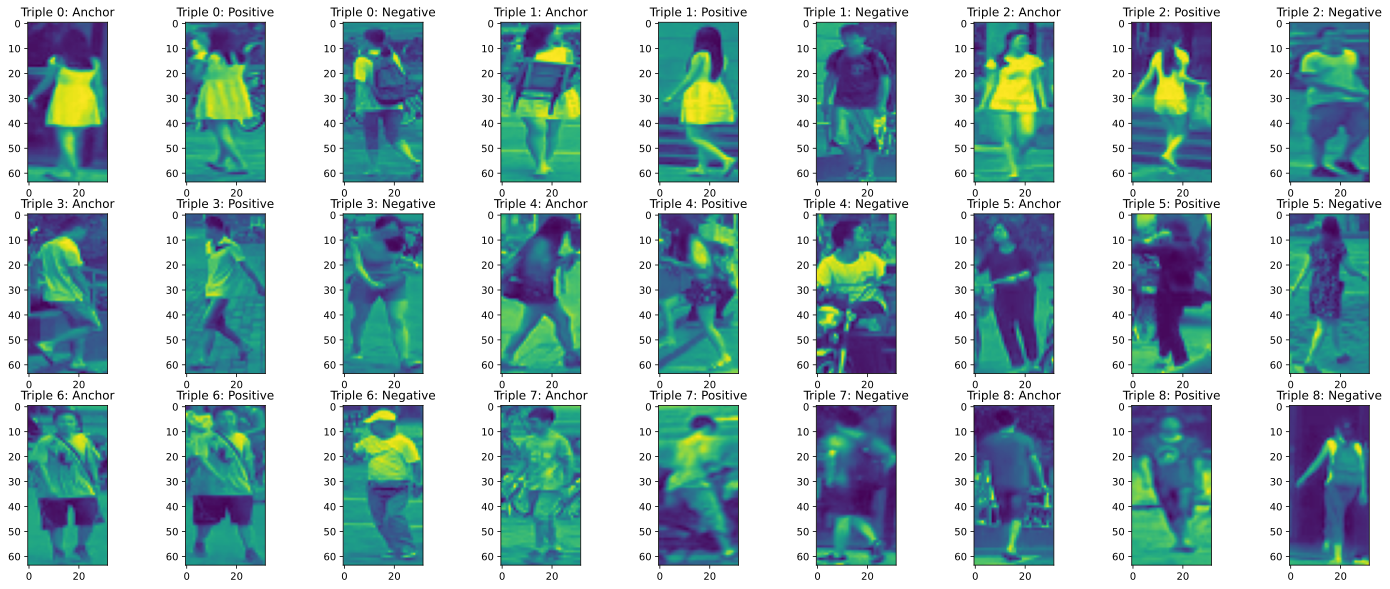

In [ ]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);

    for i in range(batch_size):

        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));

    for i in range(batch_size):

        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None

print(train_X_small.shape)
test = TripleGenerator(train_X_small, train_Y, 9)
x, _ = next(test)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')

    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Negative')

In [ ]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = layers.Conv2D(filters=filters, kernel_size=(5,5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(5,5), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)

    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)

    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):

    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))

    x = layers.Flatten()(x)

    for i in fc:
        x = fc_block(x, i, dropout)

    return x

embedding_size = 32
dummy_input = keras.Input((64, 32, 3))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs

        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)

    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

input_anchor = keras.Input((64, 32, 3), name='Anchor')
input_positive = keras.Input((64, 32, 3), name='Positive')
input_negative = keras.Input((64, 32, 3), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

tic = time.perf_counter()

triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()

triplet_network.compile(optimizer=keras.optimizers.RMSprop())

batch_size = 128
training_gen = TripleGenerator(train_X_small, train_Y, batch_size)
triplet_test_x = GetTripletData(train_X_small, train_Y, 1000)

# triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data=(triplet_test_x, None))
history = triplet_network.fit(training_gen, steps_per_epoch = 15, epochs=10, validation_data=(triplet_test_x, None))

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Training Timer: {timer} seconds')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor (InputLayer)            [(None, 64, 32, 3)]  0           []                               
                                                                                                  
 Positive (InputLayer)          [(None, 64, 32, 3)]  0           []                               
                                                                                                  
 Negative (InputLayer)          [(None, 64, 32, 3)]  0           []                               
                                                                                                  
 SiameseBranch (Functional)     (None, 32)           1108616     ['Anchor[0][0]',                 
                                                                  'Positive[0][0]',         

In [ ]:
# model = triplet_network

### Plot CMC

In [ ]:
embeddings_gallery = base_network.predict(gallery_X_small)
embeddings_probe = base_network.predict(probe_X_small)

[1.7394124e-01 1.1590346e-01 6.3110031e-02 ... 3.6700174e-12 3.5085324e-12
 1.7095068e-13]
Samples in Rank-1: 77 
Samples in Rank-5: 9  
Samples in Rank-10: 3 
Inference Timer: 0:00:00.059419 seconds


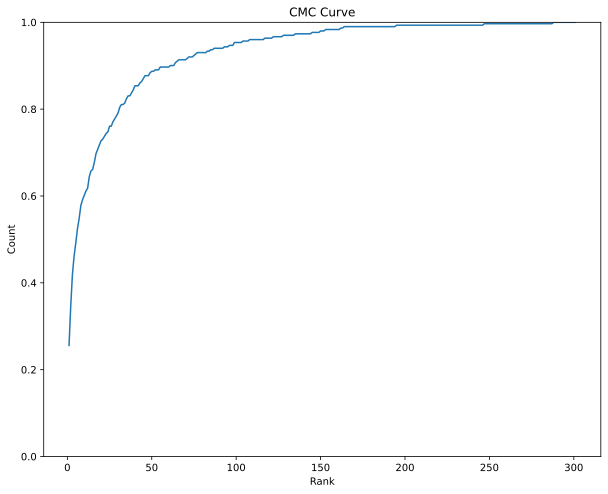

In [ ]:
tic = time.perf_counter()

ranked_hist = get_ranked_histogram_l1_distance(embeddings_gallery, gallery_Y, embeddings_probe, probe_Y)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

print(pca.explained_variance_ratio_)

print('Samples in Rank-1: %d ' % (ranked_hist[0]))
print('Samples in Rank-5: %d  ' % (ranked_hist[4]))
print('Samples in Rank-10: %d ' % (ranked_hist[9]))

toc = time.perf_counter()

timer = str(datetime.timedelta(seconds=(toc - tic)))
print(f'Inference Timer: {timer} seconds')



---



## 3. Compare the performance of the two methods.
Are there instances where the non-deep learning method works better? Comment on the respective strengths and weaknesses of the two approaches.

In [ ]:
# Written in report



---



---



# Export as PDF

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('n10477659 Final Assignment_1B.ipynb')

--2022-05-15 03:43:29--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-05-15 03:43:30 (33.2 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/n10477659 Final Assignment_1B.ipynb to pdf
[NbConvertApp] Support files will be in n10477659 Final Assignment_1B_files/
[NbConvertApp] Making directory ./n10477659 Final Assignment_1B_files
[NbConvertApp] Making directory ./n10477659 Final Assignment_1B_files
[NbConvertApp] Making directory ./n10477659 Fi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'